# Stable-Diffusion-xl-base-1.0
O SDXL consiste em um conjunto de pipelines de especialistas para difusão altente: em uma primeira etapa, o modelo base é usado para gerar latentes (ruidosos), que são posteriormente processados com um modelo de refinamento especializados para as etapas finais de remoção de ruído.

### OBS: o sistema com refinador excede a memória da GPU da conta gratuita

fonte:

# Instalando os pacotes

In [1]:
!pip install diffusers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 14.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.5 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.20.2-py3-none-any.whl size=1342633 sha256=0233058580df87af6dd60a98233c1f24572463eab7073f983b89c8d2f93f7d8c
  Stored in directory: /root/.cache/pip/wheels/dc/8b/d9/34f7a1936109e05e9bba0cc2241a6f8cd89e25959dc7aae942
Successfully built diffusers


In [2]:
!pip install invisible_watermark transformers accelerate safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.3 MB/s eta 0:00:00


# Utilizando apenas o modelo base (ruidoso)

In [3]:
from diffusers import DiffusionPipeline
import torch

# Utilizando a base e o refinador

In [4]:
# carregando a base e o refinador
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
base.to("cuda")

refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.enable_model_cpu_offload()

# Defina quantas etapas e qual % de etapas a serem executadas em cada especialista (80/20) aqui
n_steps = 40
high_noise_frac = 0.8

#prompt = "A majestic lion jumping from a big stone at night"
prompt = "Design a science research poster template that effectively communicates the key aspects of a scientific study using a limited color palette (no more than 1-2 colors). The template should include the title, authors, affiliations, abstract, introduction, methodology, results, discussion, conclusion, and references sections. Optimize the use of these limited colors, along with appropriate fonts, graphics, and whitespace, to create a visually appealing, organized, and easy-to-read poster for a diverse audience at academic or research conferences."

# executar ambos os especialistas
image = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images
image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (105 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['whitespace, to create a visually appealing, organized, and easy - to - read poster for a diverse audience at academic or research conferences.']
Token indices sequence length is longer than the specified maximum sequence length for this model (105 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['whitespace, to create a visually appealing, organized, and easy - to - read poster for a diverse audience at academic or research conferences.']


  0%|          | 0/32 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (105 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['whitespace, to create a visually appealing, organized, and easy - to - read poster for a diverse audience at academic or research conferences.']


  0%|          | 0/8 [00:00<?, ?it/s]

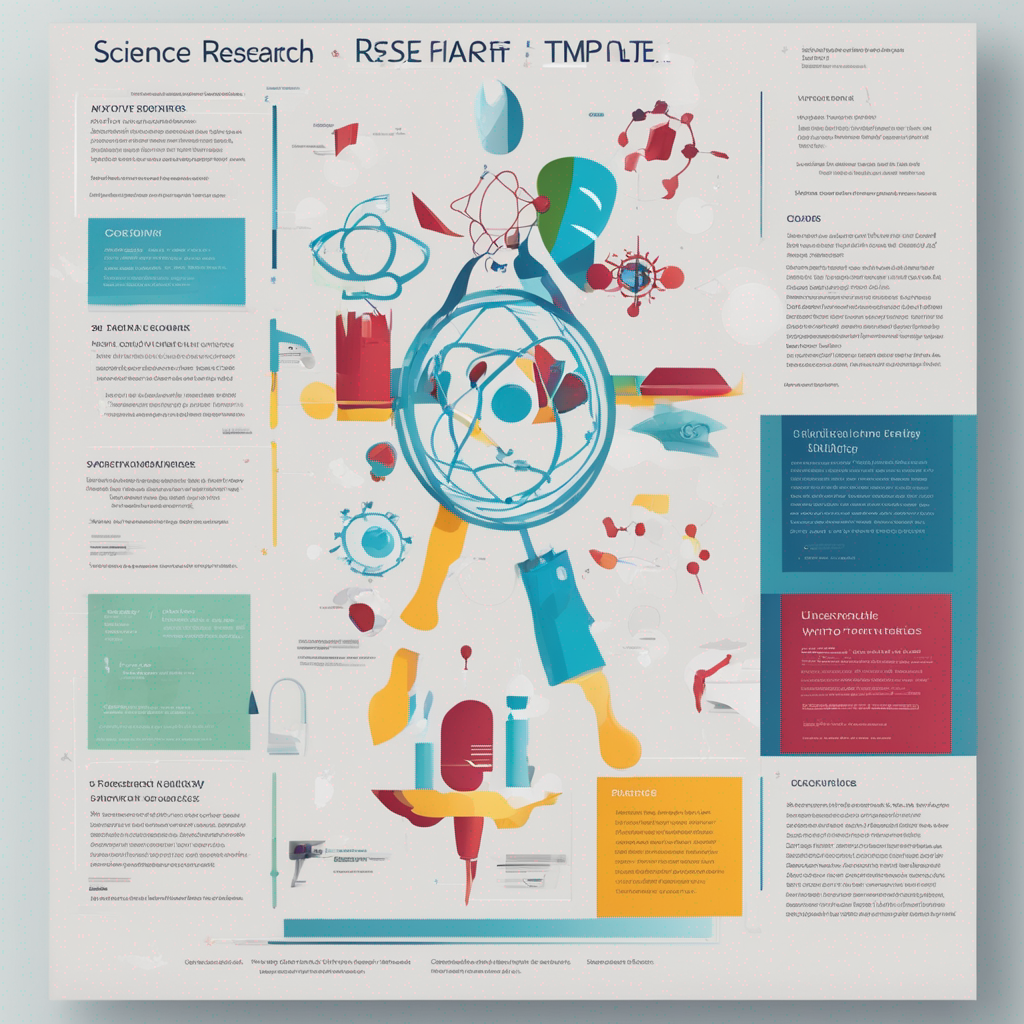

In [5]:
image